------------------------------------

<img src="MLP.jpg">
<img src="MLP_formula.png">
<img src="control_formula.png">

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class MultilayerPerceptron:
    def __init__(self, input_size, hidden_layer_sizes, output_size, activation_functions_type):
        self.input_size = input_size
        self.hidden_layer_sizes = hidden_layer_sizes
        self.output_size = output_size
        self.af_type = activation_functions_type
        self.layers = len(hidden_layer_sizes) + 1 

        self.weights = [np.random.random((input_size, hidden_layer_sizes[0]))]
        self.biases = [np.random.random((1, hidden_layer_sizes[0]))]

        for i in range(1, self.layers-1):
            self.weights.append(np.random.random((hidden_layer_sizes[i - 1], hidden_layer_sizes[i])))
            self.biases.append(np.random.random((1, hidden_layer_sizes[i])))
        self.weights.append(np.random.random((hidden_layer_sizes[self.layers-2], output_size)))
        self.biases.append(np.random.random((1, output_size)))
    
    def activation_function(self, x, type='sigmoid'):
        if type == 'sigmoid':
            return 2 / (1 + np.exp(-x)) - 1
        elif type == 'linear':
            return x
        elif type == 'ReLU':
            return np.maximum(0, x)  # ReLU activation function

    def activation_function_derivative(self, x, type='sigmoid'):
        if type == 'sigmoid':
            return (1 - self.activation_function(x, type='sigmoid') ** 2) / 2
        elif type == 'linear':
            return 1
        elif type == 'ReLU':
            return np.where(x <= 0, 0, 1)  # Derivative of ReLU

    def forward(self, x):
        layer_output = x

        for i in range(self.layers):
            layer_input = layer_output @ self.weights[i] + self.biases[i]
            layer_output = self.activation_function(layer_input, self.af_type[i])

        return layer_output

    def gradient_calculation(self, x, e, Ac):
        layer_outputs = [x]
        layer_inputs = []

        # Forward pass
        for i in range(self.layers):
            layer_input = layer_outputs[i] @ self.weights[i] + self.biases[i]
            layer_inputs.append(layer_input)
            layer_output = self.activation_function(layer_input, self.af_type[i])
            layer_outputs.append(layer_output)

        # Backpropagation
        error = (e @ np.linalg.pinv(Ac) @ np.ones([2,1])) - .01*layer_output                       #y - layer_outputs[-1]
        delta = error * self.activation_function_derivative(layer_inputs[-1], self.af_type[-1])
        grads = [{'weights': 0, 'bias': 0} for _ in range(self.layers)]

        for i in range(self.layers - 1, -1, -1):
            grads[i]['weights'] = np.sum(np.expand_dims(delta, 1) * np.expand_dims(layer_outputs[i], 2), 0)
            grads[i]['bias'] = np.sum(delta, axis=0, keepdims=True)
            if i > 0:
                # print(delta.shape, self.weights[i].shape)
                error = delta @ self.weights[i].T
                delta = error * self.activation_function_derivative(layer_inputs[i - 1], self.af_type[i - 1])
        return grads

    def train(self, x, e, Ac, update_step_num=10, learning_rate=0.001):
        for i in range(update_step_num):
            grads = self.gradient_calculation(x, e, Ac)

            for j in range(self.layers):
                self.weights[j] += learning_rate * grads[j]['weights']#np.clip(grads[j]['weights'],-1,1)
                self.biases[j] += learning_rate * grads[j]['bias']#np.clip(grads[j]['bias'],-1,1)


In [2]:
import numpy as np

class Pendulum_Nonlinear_System:
    def __init__(self, dt = 0.01):
        self.Ac = -20*np.eye(2)
        self.dt = dt
        self.t = np.linspace(0, 50, int((50-0)/dt))
        self.xd = np.array([[np.sin(self.t),np.cos(self.t)]]).T
        self.x = np.array([[.5],[.5]])
    def step(self, u):
        self.x_dot = np.array([[self.x[1,0]], [-5*self.x[0,0]**3-2*self.x[1,0]+u]])
        self.x += self.x_dot * self.dt


class Van_der_Pol_Oscillator_Nonlinear_System:
    def __init__(self, dt = 0.01):
        self.Ac = -1*np.eye(2)
        self.mu = 1
        self.dt = dt
        self.t = np.linspace(0, 50, int((50-0)/dt))
        self.xd = np.array([[np.sin(.5*self.t)+np.cos(.25*self.t),.5*np.cos(.5*self.t)-.25*np.sin(.25*self.t)]]).T
        self.x = np.array([[.5],[.5]])
    def step(self, u):
        self.x_dot = self.mu * (1-self.x[0,0]**2)*self.x[1,0] - self.x[0,0] + u
        self.x[1] += self.x_dot * self.dt
        self.x[0] += self.x[1] * self.dt

## Van der Pol Oscillator Nonlinear System

<img src="vander.png">

In [3]:
mlp = MultilayerPerceptron(input_size = 4, hidden_layer_sizes = [16], output_size = 1, activation_functions_type = ['ReLU', 'linear'])
plant = Van_der_Pol_Oscillator_Nonlinear_System()
history = {'x': np.zeros(plant.xd.shape), 'u':[]}
for i in range(len(plant.t)):
    xc = np.concatenate((np.copy(plant.x), plant.xd[i])).T
    e = np.copy(plant.x) - plant.xd[i]

    u = mlp.forward(xc)
    plant.step(u[0,0])
    history['x'][i] = plant.x
    history['u'].append(u[0,0])

    mlp.train(xc, e.T, plant.Ac, update_step_num = 1, learning_rate=0.1)


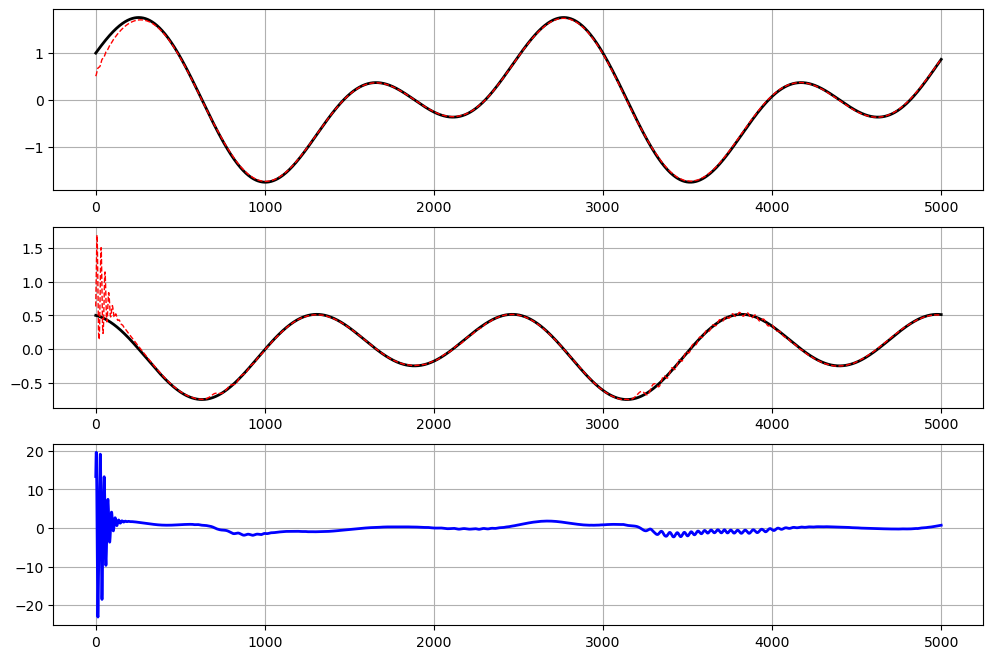

In [4]:
plt.figure(figsize=(12, 8))
plt.subplot(3,1,1)
plt.plot(plant.xd[:,0,0], 'k-', label='state 1 reference', linewidth = 2)
plt.plot(history['x'][:,0,0], 'r--', label='state 1 tracked', linewidth = 1)
plt.grid('on')
plt.subplot(3,1,2)
plt.plot(plant.xd[:,1,0], 'k-', label='state 2 reference', linewidth = 2)
plt.plot(history['x'][:,1,0], 'r--', label='state 2 tracked', linewidth = 1)
plt.grid('on')

plt.subplot(3,1,3)
plt.plot(history['u'], 'b-', label='control command', linewidth = 2)
plt.grid('on')


##  Pendulum Nonlinear System

<img src="pendulum.png">

In [9]:
mlp = MultilayerPerceptron(input_size = 4, hidden_layer_sizes = [16], output_size = 1, activation_functions_type = ['ReLU', 'linear'])
plant = Pendulum_Nonlinear_System()
history = {'x': np.zeros(plant.xd.shape), 'u':[]}
for i in range(len(plant.t)):
    xc = np.concatenate((np.copy(plant.x), plant.xd[i])).T
    e = np.copy(plant.x) - plant.xd[i]

    u = mlp.forward(xc)
    plant.step(u[0,0])
    history['x'][i] = plant.x
    history['u'].append(u[0,0])

    mlp.train(xc, e.T, plant.Ac, update_step_num = 1, learning_rate=0.1)


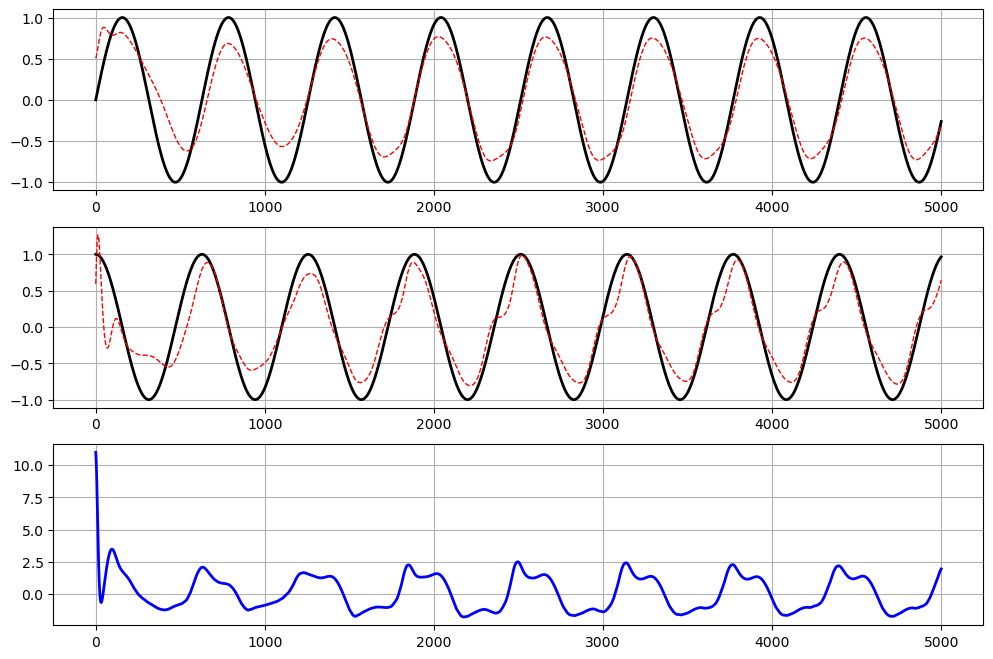

In [10]:
plt.figure(figsize=(12, 8))
plt.subplot(3,1,1)
plt.plot(plant.xd[:,0,0], 'k-', label='state 1 reference', linewidth = 2)
plt.plot(history['x'][:,0,0], 'r--', label='state 1 tracked', linewidth = 1)
plt.grid('on')
plt.subplot(3,1,2)
plt.plot(plant.xd[:,1,0], 'k-', label='state 2 reference', linewidth = 2)
plt.plot(history['x'][:,1,0], 'r--', label='state 2 tracked', linewidth = 1)
plt.grid('on')

plt.subplot(3,1,3)
plt.plot(history['u'], 'b-', label='control command', linewidth = 2)
plt.grid('on')
